# Week 4: NLP Disaster Tweets

### Table of Contents

1. [Abstract](#abstract)
2. [Data](#data)
    - 2.1 [Load Data](#load)
    - 2.2 [Exploratory Data Analysis (EDA)](#EDA)
3. [Exploratory Data Analysis](#eda)
    - 3.1 [Stacked LSTM](#StackedL)
    - 3.2 [Stacked GRU](#StackG)
    - 3.3 [Gridsearch GRU](#Gr)
4. [Conclusion](#conclusion)
5. [Reference](#Ref)

## 1. Abstract
The widespread use of smartphones enables people to report observed emergencies in real-time. As a result, an increasing number of organizations, such as disaster relief agencies and news outlets, are interested in monitoring Twitter through various programs. However, determining whether someone’s words truly indicate a disaster is not always straightforward. For this reason, we have developed a Natural Language Processing (NLP) solution to automatically analyze the sentiment and content of thousands of tweets. The primary task of this NLP model is to identify and classify whether the tweet text describes an actual weather disaster.

## 2. Data

In [2]:
import os
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

2024-11-10 15:21:35.079367: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 15:21:35.139017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 15:21:36.047354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2.1 Data Loading and Cleaning

In [6]:
# Load the training data
train = pd.read_csv('train.csv')
# Display data dimensions and a sample
print("Training Data Dimensions:", train_data.shape)
print("Sample of Training Data:")
train.head()

Training Data Dimensions: (7613, 5)
Sample of Training Data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print('Null Values')
train.isnull().sum()

Null Values


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The test data consists of 3263 tweets that have the following features: ID, keyword, loctation, text (main body of tweet), and target. Few of the tweets have a keyword or location. There are 26 tweets with a missing keyword and 1105 (about 1/3) with a missing location.

In [8]:
test = pd.read_csv('test.csv')
print("Test Data Shape:", test.shape)
print("Test Data Example:")
test.head()

Test Data Shape: (3263, 4)
Test Data Example:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
print('Null Values')
test.isnull().sum()

Null Values


id             0
keyword       26
location    1105
text           0
dtype: int64

The dataset in this experiment is split into training and testing sets at a 7:3 ratio. This split is based on the ID.

In [11]:
#Analyze the data format submitted to Kaggle
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### 2.2 Exploratory Data Analysis (EDA)

In [9]:
#Detect the data types of each feature in the dataset
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [10]:
#Calculate the relative frequency of each class in the target category.
train.target.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [12]:
#Replacing all instances of the float 'NAN' in the dataset with the string 'None' to standardize data types in the keyword and location columns. This allows us to easily examine unique keywords in the following cell.
train = train.replace(np.nan, 'None')
print("Unique Keywords in Train:", len(np.unique(train.keyword)))
np.unique(train.keyword)

Unique Keywords in Train: 222


array(['None', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', '

In [13]:
train.keyword.value_counts()

keyword
None                     61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

Text(0, 0.5, 'Frequency')

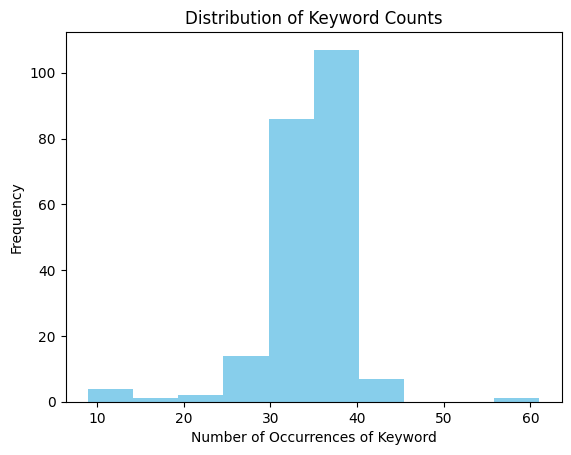

In [16]:
plt.hist(train.keyword.value_counts(), color='skyblue')
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurrences of Keyword')
plt.ylabel('Frequency')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'None'),
  Text(1, 0, 'fatalities'),
  Text(2, 0, 'deluge'),
  Text(3, 0, 'armageddon'),
  Text(4, 0, 'sinking'),
  Text(5, 0, 'damage'),
  Text(6, 0, 'harm'),
  Text(7, 0, 'body%20bags'),
  Text(8, 0, 'evacuate'),
  Text(9, 0, 'fear'),
  Text(10, 0, 'outbreak'),
  Text(11, 0, 'siren'),
  Text(12, 0, 'twister'),
  Text(13, 0, 'windstorm'),
  Text(14, 0, 'collided'),
  Text(15, 0, 'sinkhole'),
  Text(16, 0, 'sunk'),
  Text(17, 0, 'hellfire'),
  Text(18, 0, 'weapon'),
  Text(19, 0, 'weapons')])

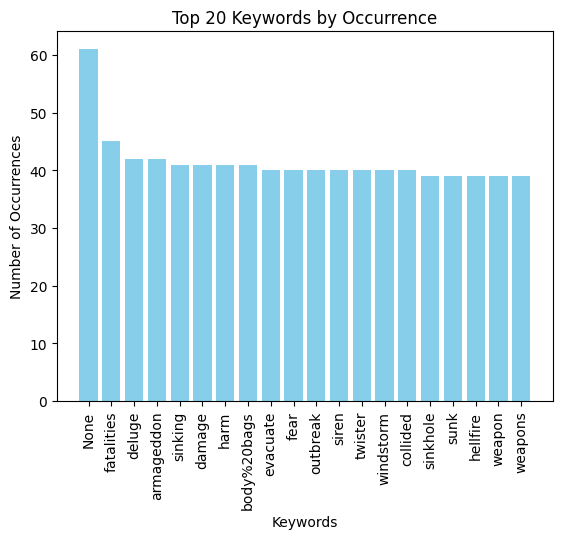

In [15]:
keyword_counts = train.keyword.value_counts().head(20)  # 显示前20个关键词
plt.bar(keyword_counts.index, keyword_counts.values, color='skyblue')
plt.title('Top 20 Keywords by Occurrence')
plt.xlabel('Keywords')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)


Text(0.5, 1.0, 'Word Cloud of Keywords')

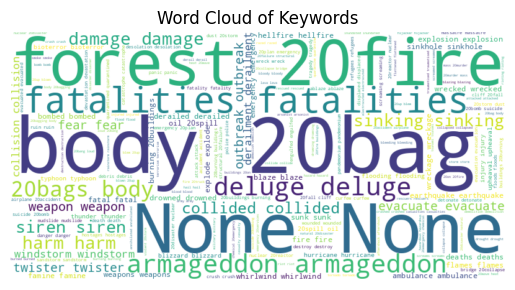

In [19]:
from wordcloud import WordCloud

keyword_text = ' '.join(train.keyword.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keyword_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')

While the keywords in the tweets show a fairly balanced distribution, the locations differ significantly. There are 3,342 unique locations, which, excluding the entries labeled 'None,' results in an average of roughly 2 tweets per unique location.

In [16]:
train.location.value_counts()

location
None                            2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

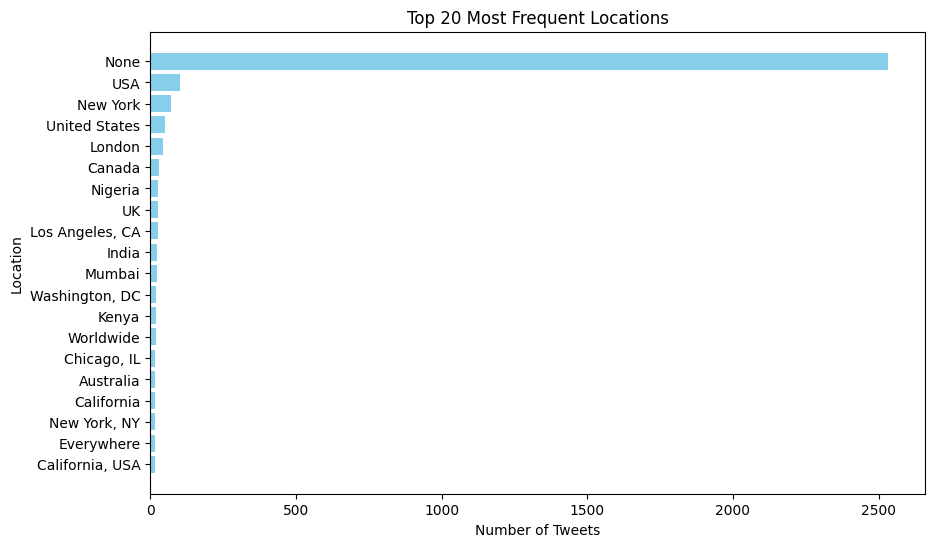

In [28]:
top_locations = train.location.value_counts().head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_locations.index, top_locations.values, color='skyblue')  
plt.title('Top 20 Most Frequent Locations')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.gca().invert_yaxis() 
plt.show()


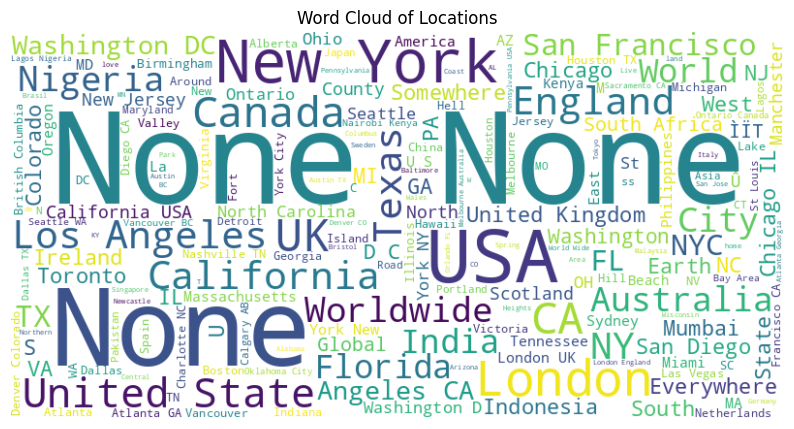

In [23]:
from wordcloud import WordCloud

location_text = ' '.join(train.location.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(location_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Locations')
plt.show()


In [26]:
#Calculating the average number of characters in each tweet text body.
text_characters = [len(text) for text in train.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 101.0 characters


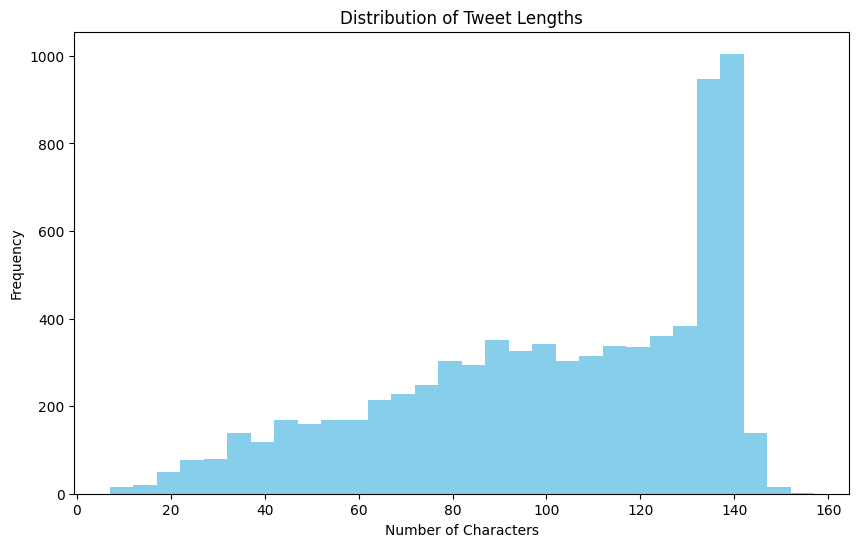

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(text_characters, bins=30, color='skyblue')  # 设置为天蓝色
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


Examing test data types and replacing the float "NAN" with the string "None" for consistency in the keyword and location attribute data types.

In [30]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [31]:
test = test.replace(np.nan, 'None')

In [32]:
test.keyword.value_counts()

keyword
None             26
deluged          23
demolished       22
rubble           22
snowstorm        21
                 ..
threat            5
fatalities        5
forest%20fire     5
inundation        4
epicentre         1
Name: count, Length: 222, dtype: int64

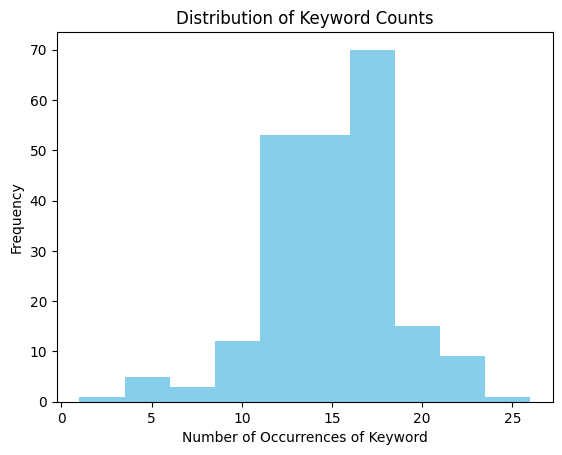

In [33]:
plt.hist(test.keyword.value_counts(), color='skyblue')  
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurrences of Keyword')
plt.ylabel('Frequency')
plt.show()

In [34]:
test.location.value_counts()

location
None                      1105
New York                    38
USA                         37
Worldwide                   16
United States               15
                          ... 
Quezon City                  1
LanÌ¼s                       1
USA,Washington,Seattle       1
Roanoke, VA                  1
Brussels, Belgium            1
Name: count, Length: 1603, dtype: int64

In [41]:
text_characters = [len(text) for text in test.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 102.1 characters


In [42]:
train_X, val_X, train_y, val_y = train_test_split(train['text'], train['target'], test_size=0.3, random_state=1)

In [43]:
print("Train_X Shape:",train_X.shape)
print("Train_y Shape:",train_y.shape)
print("Validation_X Shape:",val_X.shape)
print("Validation_y Shape:",val_y.shape)

Train_X Shape: (5329,)
Train_y Shape: (5329,)
Validation_X Shape: (2284,)
Validation_y Shape: (2284,)


### 2.3 Processing Tweet Text into Matrix Form


In [52]:
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, max_df = 0.98)
train_tfidf = tfidf.fit_transform(train_X)
train_tfidf = np.array(train_tfidf.todense())
print("Embedded Training Data Shape:", train_tfidf.shape)
print("Example of Embedded Data:")
pd.DataFrame(train_tfidf).head()

Embedded Training Data Shape: (5329, 4987)
Example of Embedded Data:


,0,1,2,3,4,5,6,7,8,9,...,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.287921,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [47]:
val_tfidf = tfidf.transform(val_X)
val_tfidf = np.array(val_tfidf.todense())
print("Shape of embedded validation data:", val_tfidf.shape)

Shape of embedded validation data: (2284, 4987)


In [48]:
train_matrix = np.reshape(train_tfidf, (train_tfidf.shape[0], 1, train_tfidf.shape[1]))
val_matrix = np.reshape(val_tfidf, (val_tfidf.shape[0], 1, val_tfidf.shape[1]))
train_y = np.array(train_y)
val_y = np.array(val_y)
train_y = train_y.reshape(train_y.shape[0], 1)
val_y = val_y.reshape(val_y.shape[0], 1)

## 3. Model

The chosen model architecture for this project is the Recurrent Neural Network (RNN). RNNs are unique in that they can pass information from a previous time step to the current one, making them highly suitable for sequential data such as text and time-series data. In an RNN, each time step's input relies not only on the current input but also on the hidden state from previous time steps. This enables the model to "remember" prior context, capturing temporal dependencies and contextual relationships within the data.

RNNs have several variants and improved architectures, with Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) being the most common. LSTM incorporates forget, input, and output gates to handle long-term dependencies in lengthy sequences effectively, addressing the gradient vanishing and exploding problems that traditional RNNs face in long sequences. GRU, on the other hand, is a simplified version of LSTM, using update and reset gates to achieve similar outcomes with a lighter structure.

Due to these features, RNNs are widely used in natural language processing, speech recognition, and time-series forecasting.

### 3.1 Stacked LSTM
Building a simple RNN model with two LSTM layers containing 32 and 4 units, respectively. Additionally, these layers apply a dropout and recurrent dropout rate of 50%. Finally, the output from the LSTM layers is passed to a dense layer with a sigmoid activation function to generate the model’s classification result.

In [34]:
# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer
model.add(LSTM(
    units=32,
    return_sequences=True,
    dropout=0.5,
    recurrent_dropout=0.5,
    input_shape=(train_matrix.shape[1], train_matrix.shape[2])
))

# Add the second LSTM layer
model.add(LSTM(
    units=4,
    return_sequences=True,
    dropout=0.5,
    recurrent_dropout=0.5
))

# Add the output dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', AUC(name='auc')]
)

# Train the model
history = model.fit(
    train_matrix,
    train_y,
    epochs=10,
    batch_size=1,
    validation_data=(val_matrix, val_y)
)

Epoch 1/10
5329/5329 [==============================] - 22s 4ms/step - loss: 0.6125 - accuracy: 0.6637 - auc: 0.7183 - val_loss: 0.4817 - val_accuracy: 0.7833 - val_auc: 0.8491
Epoch 2/10
5329/5329 [==============================] - 18s 3ms/step - loss: 0.4683 - accuracy: 0.7898 - auc: 0.8518 - val_loss: 0.4649 - val_accuracy: 0.7916 - val_auc: 0.8517
Epoch 3/10
5329/5329 [==============================] - 19s 3ms/step - loss: 0.4393 - accuracy: 0.8011 - auc: 0.8685 - val_loss: 0.4576 - val_accuracy: 0.7907 - val_auc: 0.8526
Epoch 4/10
5329/5329 [==============================] - 19s 3ms/step - loss: 0.4074 - accuracy: 0.8182 - auc: 0.8890 - val_loss: 0.4668 - val_accuracy: 0.7955 - val_auc: 0.8484
Epoch 5/10
5329/5329 [==============================] - 18s 3ms/step - loss: 0.3995 - accuracy: 0.8260 - auc: 0.8911 - val_loss: 0.4629 - val_accuracy: 0.7951 - val_auc: 0.8440
Epoch 6/10
5329/5329 [==============================] - 19s 3ms/step - loss: 0.3833 - accuracy: 0.8266 - auc: 0.902

In [36]:
#Testing a single-layer LSTM with 32 units, using the same dropout strategy as the previous model.
# Create a single-layer LSTM model
single_lstm = Sequential([
    LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    Dense(1, activation='sigmoid')
])

# Compile the model
single_lstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', AUC(name='auc')]
)

# Train the model
single_lstm_history = single_lstm.fit(
    train_matrix, train_y,
    epochs=10,
    batch_size=1,
    validation_data=(val_matrix, val_y)
)

Epoch 1/10
5329/5329 [==============================] - 18s 3ms/step - loss: 0.5890 - accuracy: 0.6943 - auc: 0.7473 - val_loss: 0.4782 - val_accuracy: 0.7850 - val_auc: 0.8432
Epoch 2/10
5329/5329 [==============================] - 16s 3ms/step - loss: 0.4640 - accuracy: 0.7906 - auc: 0.8560 - val_loss: 0.4645 - val_accuracy: 0.7763 - val_auc: 0.8467
Epoch 3/10
5329/5329 [==============================] - 16s 3ms/step - loss: 0.4207 - accuracy: 0.8062 - auc: 0.8803 - val_loss: 0.4623 - val_accuracy: 0.7907 - val_auc: 0.8482
Epoch 4/10
5329/5329 [==============================] - 16s 3ms/step - loss: 0.4026 - accuracy: 0.8185 - auc: 0.8894 - val_loss: 0.4630 - val_accuracy: 0.7846 - val_auc: 0.8491
Epoch 5/10
5329/5329 [==============================] - 16s 3ms/step - loss: 0.3867 - accuracy: 0.8251 - auc: 0.8998 - val_loss: 0.4672 - val_accuracy: 0.7863 - val_auc: 0.8479
Epoch 6/10
5329/5329 [==============================] - 16s 3ms/step - loss: 0.3698 - accuracy: 0.8349 - auc: 0.909

### 3.2 Stacked GRU
Implementing a straightforward RNN with two Gated Recurrent Unit (GRU) layers, the first with 32 units and the second with 4 units. Both layers utilize a dropout and recurrent dropout rate of 50%. The output from the GRU layers is then used for subsequent processing.

In [38]:
stacked_gru = Sequential([
    GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    GRU(4, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    Dense(1, activation='sigmoid')
])

stacked_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')]
)

stacked_gru_history = stacked_gru.fit(
    train_matrix, train_y, 
    epochs=10, batch_size=1, 
    validation_data=(val_matrix, val_y)
)

Epoch 1/10
5329/5329 [==============================] - 24s 4ms/step - loss: 0.5986 - accuracy: 0.6804 - auc: 0.7275 - val_loss: 0.4809 - val_accuracy: 0.7820 - val_auc: 0.8399
Epoch 2/10
5329/5329 [==============================] - 21s 4ms/step - loss: 0.4692 - accuracy: 0.7872 - auc: 0.8477 - val_loss: 0.4581 - val_accuracy: 0.7938 - val_auc: 0.8498
Epoch 3/10
5329/5329 [==============================] - 21s 4ms/step - loss: 0.4304 - accuracy: 0.8078 - auc: 0.8747 - val_loss: 0.4529 - val_accuracy: 0.7933 - val_auc: 0.8528
Epoch 4/10
5329/5329 [==============================] - 21s 4ms/step - loss: 0.4060 - accuracy: 0.8221 - auc: 0.8895 - val_loss: 0.4643 - val_accuracy: 0.7907 - val_auc: 0.8503
Epoch 5/10
5329/5329 [==============================] - 21s 4ms/step - loss: 0.3953 - accuracy: 0.8294 - auc: 0.8942 - val_loss: 0.4668 - val_accuracy: 0.7912 - val_auc: 0.8489
Epoch 6/10
5329/5329 [==============================] - 21s 4ms/step - loss: 0.3724 - accuracy: 0.8414 - auc: 0.907

### 3.3 Gridsearch GRU
To implement a simple Recurrent Neural Network (RNN) using a Gated Recurrent Unit (GRU), we performed a grid search to optimize several key hyperparameters. Due to hardware limitations, specifically memory and time constraints, the search space was restricted to the following hyperparameters:

- **Dropout rate**: We tested three levels: 35%, 50%, and 65%. Dropout is used as a regularization technique to prevent overfitting by randomly setting a fraction of input units to zero during training.
- **Batch size**: We evaluated batch sizes of 1, 32, and 128, as the choice of batch size affects both training efficiency and the model's stability.
- **Number of units in the GRU layer**: We experimented with 4, 16, and 64 units, as the number of units determines the model's capacity and computational complexity.

Given the current hardware limitations, we could only explore this smaller subset of hyperparameters. However, with access to more powerful equipment, we would have liked to expand the search to include additional hyperparameters and broader ranges to potentially improve model performance further.

In [244]:
for dropout in [0.2, 0.35, 0.5, 0.65]:
    for batch_size in [1, 32, 128]:
        for nodes in [4, 16, 64]:
            print(f"\nRNN with dropout rate: {dropout}, batch_size: {batch_size}, nodes: {nodes}")
            model = Sequential()
            model.add(GRU(nodes, return_sequences=True, dropout=dropout, recurrent_dropout=dropout,
                          input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
            model.fit(train_matrix, train_y, epochs=5, batch_size=batch_size, validation_data=(val_matrix, val_y))


RNN with dropout rate: 0.35 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 43s 8ms/step - loss: 0.5880 - accuracy: 0.6936 - auc: 0.7638 - val_loss: 0.4773 - val_accuracy: 0.7903 - val_auc: 0.8503
Epoch 2/5
5329/5329 [==============================] - 51s 10ms/step - loss: 0.4289 - accuracy: 0.8127 - auc: 0.8760 - val_loss: 0.4519 - val_accuracy: 0.7920 - val_auc: 0.8552
Epoch 3/5
5329/5329 [==============================] - 44s 8ms/step - loss: 0.3747 - accuracy: 0.8416 - auc: 0.9064 - val_loss: 0.4648 - val_accuracy: 0.7982 - val_auc: 0.8551
Epoch 4/5
5329/5329 [==============================] - 46s 9ms/step - loss: 0.3526 - accuracy: 0.8474 - auc: 0.9176 - val_loss: 0.4705 - val_accuracy: 0.7938 - val_auc: 0.8543
Epoch 5/5
5329/5329 [==============================] - 50s 9ms/step - loss: 0.3282 - accuracy: 0.8589 - auc: 0.9302 - val_loss: 0.4846 - val_accuracy: 0.7916 - val_auc: 0.8507



RNN with dropout rate: 0.35 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 47s 8ms/step - loss: 0.5645 - accuracy: 0.7174 - auc: 0.7713 - val_loss: 0.4644 - val_accuracy: 0.7868 - val_auc: 0.8477
Epoch 2/5
5329/5329 [==============================] - 45s 8ms/step - loss: 0.4135 - accuracy: 0.8217 - auc: 0.8843 - val_loss: 0.4596 - val_accuracy: 0.7881 - val_auc: 0.8554
Epoch 3/5
5329/5329 [==============================] - 45s 8ms/step - loss: 0.3668 - accuracy: 0.8442 - auc: 0.9115 - val_loss: 0.4598 - val_accuracy: 0.7960 - val_auc: 0.8555
Epoch 4/5
5329/5329 [==============================] - 41s 8ms/step - loss: 0.3397 - accuracy: 0.8503 - auc: 0.9251 - val_loss: 0.4754 - val_accuracy: 0.7863 - val_auc: 0.8485
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.3174 - accuracy: 0.8645 - auc: 0.9341 - val_loss: 0.4806 - val_accuracy: 0.7877 - val_auc: 0.8474



RNN with dropout rate: 0.35 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.5506 - accuracy: 0.7264 - auc: 0.7824 - val_loss: 0.4623 - val_accuracy: 0.7960 - val_auc: 0.8504
Epoch 2/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4154 - accuracy: 0.8155 - auc: 0.8858 - val_loss: 0.4605 - val_accuracy: 0.7955 - val_auc: 0.8502
Epoch 3/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.3723 - accuracy: 0.8399 - auc: 0.9077 - val_loss: 0.4611 - val_accuracy: 0.7964 - val_auc: 0.8494
Epoch 4/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.3373 - accuracy: 0.8534 - auc: 0.9254 - val_loss: 0.4662 - val_accuracy: 0.7885 - val_auc: 0.8473
Epoch 5/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.3096 - accuracy: 0.8656 - auc: 0.9371 - val_loss: 0.4782 - val_accuracy: 0.7837 - val_auc: 0.8477



RNN with dropout rate: 0.35 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6733 - accuracy: 0.5830 - auc: 0.6470 - val_loss: 0.6478 - val_accuracy: 0.6265 - val_auc: 0.8345
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6148 - accuracy: 0.6847 - auc: 0.8596 - val_loss: 0.5895 - val_accuracy: 0.7364 - val_auc: 0.8484
Epoch 3/5
167/167 [==============================] - 3s 18ms/step - loss: 0.5391 - accuracy: 0.7851 - auc: 0.8846 - val_loss: 0.5308 - val_accuracy: 0.7855 - val_auc: 0.8535
Epoch 4/5
167/167 [==============================] - 3s 15ms/step - loss: 0.4729 - accuracy: 0.8148 - auc: 0.8984 - val_loss: 0.4919 - val_accuracy: 0.7982 - val_auc: 0.8560
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4225 - accuracy: 0.8347 - auc: 0.9108 - val_loss: 0.4687 - val_accuracy: 0.7995 - val_auc: 0.8567



RNN with dropout rate: 0.35 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 6s 14ms/step - loss: 0.6671 - accuracy: 0.5898 - auc: 0.6743 - val_loss: 0.6287 - val_accuracy: 0.6716 - val_auc: 0.8421
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5706 - accuracy: 0.7463 - auc: 0.8635 - val_loss: 0.5307 - val_accuracy: 0.7855 - val_auc: 0.8509
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4592 - accuracy: 0.8185 - auc: 0.8897 - val_loss: 0.4731 - val_accuracy: 0.7977 - val_auc: 0.8533
Epoch 4/5
167/167 [==============================] - 2s 12ms/step - loss: 0.3887 - accuracy: 0.8414 - auc: 0.9137 - val_loss: 0.4549 - val_accuracy: 0.7890 - val_auc: 0.8539
Epoch 5/5
167/167 [==============================] - 3s 21ms/step - loss: 0.3570 - accuracy: 0.8503 - auc: 0.9222 - val_loss: 0.4560 - val_accuracy: 0.7894 - val_auc: 0.8525



RNN with dropout rate: 0.35 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 5s 14ms/step - loss: 0.6421 - accuracy: 0.6386 - auc: 0.7447 - val_loss: 0.5627 - val_accuracy: 0.7588 - val_auc: 0.8497
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4780 - accuracy: 0.8002 - auc: 0.8717 - val_loss: 0.4629 - val_accuracy: 0.7907 - val_auc: 0.8529
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.3863 - accuracy: 0.8347 - auc: 0.9048 - val_loss: 0.4555 - val_accuracy: 0.7912 - val_auc: 0.8537
Epoch 4/5
167/167 [==============================] - 3s 16ms/step - loss: 0.3432 - accuracy: 0.8503 - auc: 0.9243 - val_loss: 0.4687 - val_accuracy: 0.7881 - val_auc: 0.8489
Epoch 5/5
167/167 [==============================] - 3s 17ms/step - loss: 0.3173 - accuracy: 0.8626 - auc: 0.9350 - val_loss: 0.4933 - val_accuracy: 0.7868 - val_auc: 0.8430



RNN with dropout rate: 0.35 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 4s 27ms/step - loss: 0.6861 - accuracy: 0.5761 - auc: 0.6020 - val_loss: 0.6767 - val_accuracy: 0.5845 - val_auc: 0.7871
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6683 - accuracy: 0.5761 - auc: 0.8090 - val_loss: 0.6604 - val_accuracy: 0.5933 - val_auc: 0.8332
Epoch 3/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6482 - accuracy: 0.6057 - auc: 0.8795 - val_loss: 0.6435 - val_accuracy: 0.6305 - val_auc: 0.8435
Epoch 4/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6261 - accuracy: 0.6553 - auc: 0.8964 - val_loss: 0.6242 - val_accuracy: 0.6747 - val_auc: 0.8474
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5999 - accuracy: 0.7153 - auc: 0.9017 - val_loss: 0.6031 - val_accuracy: 0.7158 - val_auc: 0.8502

RNN with dropout rate: 0.35 batch_size: 128 nodes: 16


Epoch 1/5
42/42 [==============================] - 6s 42ms/step - loss: 0.6845 - accuracy: 0.5703 - auc: 0.6132 - val_loss: 0.6716 - val_accuracy: 0.5889 - val_auc: 0.8212
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6584 - accuracy: 0.5999 - auc: 0.8386 - val_loss: 0.6458 - val_accuracy: 0.6283 - val_auc: 0.8444
Epoch 3/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6251 - accuracy: 0.6562 - auc: 0.8813 - val_loss: 0.6141 - val_accuracy: 0.6926 - val_auc: 0.8501
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5810 - accuracy: 0.7439 - auc: 0.8935 - val_loss: 0.5771 - val_accuracy: 0.7557 - val_auc: 0.8537
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5322 - accuracy: 0.7992 - auc: 0.9043 - val_loss: 0.5408 - val_accuracy: 0.7846 - val_auc: 0.8538



RNN with dropout rate: 0.35 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 4s 29ms/step - loss: 0.6722 - accuracy: 0.5845 - auc: 0.6636 - val_loss: 0.6444 - val_accuracy: 0.6353 - val_auc: 0.8420
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6097 - accuracy: 0.6921 - auc: 0.8790 - val_loss: 0.5864 - val_accuracy: 0.7417 - val_auc: 0.8511
Epoch 3/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5343 - accuracy: 0.7958 - auc: 0.8905 - val_loss: 0.5260 - val_accuracy: 0.7929 - val_auc: 0.8545
Epoch 4/5
42/42 [==============================] - 1s 14ms/step - loss: 0.4591 - accuracy: 0.8260 - auc: 0.9052 - val_loss: 0.4842 - val_accuracy: 0.8004 - val_auc: 0.8559
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.4049 - accuracy: 0.8469 - auc: 0.9170 - val_loss: 0.4619 - val_accuracy: 0.7999 - val_auc: 0.8558



RNN with dropout rate: 0.5 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 41s 7ms/step - loss: 0.6150 - accuracy: 0.6596 - auc: 0.7342 - val_loss: 0.5015 - val_accuracy: 0.7815 - val_auc: 0.8424
Epoch 2/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.4766 - accuracy: 0.7831 - auc: 0.8458 - val_loss: 0.4599 - val_accuracy: 0.7877 - val_auc: 0.8522
Epoch 3/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4192 - accuracy: 0.8118 - auc: 0.8820 - val_loss: 0.4552 - val_accuracy: 0.7955 - val_auc: 0.8518
Epoch 4/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.4015 - accuracy: 0.8257 - auc: 0.8928 - val_loss: 0.4610 - val_accuracy: 0.7907 - val_auc: 0.8495
Epoch 5/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.3734 - accuracy: 0.8394 - auc: 0.9075 - val_loss: 0.4658 - val_accuracy: 0.7920 - val_auc: 0.8505



RNN with dropout rate: 0.5 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 43s 8ms/step - loss: 0.5812 - accuracy: 0.6964 - auc: 0.7547 - val_loss: 0.4781 - val_accuracy: 0.7828 - val_auc: 0.8445
Epoch 2/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4580 - accuracy: 0.7911 - auc: 0.8581 - val_loss: 0.4606 - val_accuracy: 0.7933 - val_auc: 0.8499
Epoch 3/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.4132 - accuracy: 0.8150 - auc: 0.8859 - val_loss: 0.4603 - val_accuracy: 0.7912 - val_auc: 0.8500
Epoch 4/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.3817 - accuracy: 0.8296 - auc: 0.9026 - val_loss: 0.4581 - val_accuracy: 0.7885 - val_auc: 0.8515
Epoch 5/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.3680 - accuracy: 0.8409 - auc: 0.9106 - val_loss: 0.4677 - val_accuracy: 0.7877 - val_auc: 0.8504



RNN with dropout rate: 0.5 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.5693 - accuracy: 0.7074 - auc: 0.7612 - val_loss: 0.4799 - val_accuracy: 0.7868 - val_auc: 0.8373
Epoch 2/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4605 - accuracy: 0.7964 - auc: 0.8533 - val_loss: 0.4635 - val_accuracy: 0.7916 - val_auc: 0.8476
Epoch 3/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4122 - accuracy: 0.8176 - auc: 0.8861 - val_loss: 0.4612 - val_accuracy: 0.7951 - val_auc: 0.8470
Epoch 4/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.3847 - accuracy: 0.8289 - auc: 0.9009 - val_loss: 0.4649 - val_accuracy: 0.7877 - val_auc: 0.8451
Epoch 5/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.3715 - accuracy: 0.8382 - auc: 0.9079 - val_loss: 0.4632 - val_accuracy: 0.7890 - val_auc: 0.8478



RNN with dropout rate: 0.5 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6773 - accuracy: 0.5727 - auc: 0.6253 - val_loss: 0.6578 - val_accuracy: 0.5985 - val_auc: 0.8278
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6355 - accuracy: 0.6350 - auc: 0.8344 - val_loss: 0.6133 - val_accuracy: 0.6970 - val_auc: 0.8416
Epoch 3/5
167/167 [==============================] - 4s 22ms/step - loss: 0.5740 - accuracy: 0.7467 - auc: 0.8627 - val_loss: 0.5582 - val_accuracy: 0.7653 - val_auc: 0.8473
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5111 - accuracy: 0.7908 - auc: 0.8782 - val_loss: 0.5139 - val_accuracy: 0.7907 - val_auc: 0.8509
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4711 - accuracy: 0.8039 - auc: 0.8815 - val_loss: 0.4874 - val_accuracy: 0.7920 - val_auc: 0.8522



RNN with dropout rate: 0.5 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6672 - accuracy: 0.5907 - auc: 0.6744 - val_loss: 0.6310 - val_accuracy: 0.6708 - val_auc: 0.8390
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5836 - accuracy: 0.7335 - auc: 0.8394 - val_loss: 0.5406 - val_accuracy: 0.7837 - val_auc: 0.8511
Epoch 3/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4903 - accuracy: 0.7951 - auc: 0.8691 - val_loss: 0.4874 - val_accuracy: 0.7912 - val_auc: 0.8527
Epoch 4/5
167/167 [==============================] - 3s 18ms/step - loss: 0.4327 - accuracy: 0.8155 - auc: 0.8874 - val_loss: 0.4623 - val_accuracy: 0.7938 - val_auc: 0.8518
Epoch 5/5
167/167 [==============================] - 3s 16ms/step - loss: 0.3942 - accuracy: 0.8302 - auc: 0.9037 - val_loss: 0.4546 - val_accuracy: 0.7894 - val_auc: 0.8535



RNN with dropout rate: 0.5 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 7s 15ms/step - loss: 0.6494 - accuracy: 0.6243 - auc: 0.7133 - val_loss: 0.5781 - val_accuracy: 0.7417 - val_auc: 0.8443
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5109 - accuracy: 0.7784 - auc: 0.8466 - val_loss: 0.4781 - val_accuracy: 0.7859 - val_auc: 0.8519
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4333 - accuracy: 0.8077 - auc: 0.8768 - val_loss: 0.4570 - val_accuracy: 0.7912 - val_auc: 0.8505
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4007 - accuracy: 0.8185 - auc: 0.8938 - val_loss: 0.4599 - val_accuracy: 0.7903 - val_auc: 0.8479
Epoch 5/5
167/167 [==============================] - 2s 12ms/step - loss: 0.3662 - accuracy: 0.8369 - auc: 0.9119 - val_loss: 0.4666 - val_accuracy: 0.7877 - val_auc: 0.8466



RNN with dropout rate: 0.5 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 5s 44ms/step - loss: 0.6880 - accuracy: 0.5673 - auc: 0.5733 - val_loss: 0.6800 - val_accuracy: 0.5806 - val_auc: 0.7765
Epoch 2/5
42/42 [==============================] - 1s 25ms/step - loss: 0.6741 - accuracy: 0.5737 - auc: 0.7671 - val_loss: 0.6667 - val_accuracy: 0.5832 - val_auc: 0.8318
Epoch 3/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6586 - accuracy: 0.5830 - auc: 0.8456 - val_loss: 0.6523 - val_accuracy: 0.5994 - val_auc: 0.8436
Epoch 4/5
42/42 [==============================] - 1s 16ms/step - loss: 0.6402 - accuracy: 0.6185 - auc: 0.8754 - val_loss: 0.6363 - val_accuracy: 0.6379 - val_auc: 0.8482
Epoch 5/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6204 - accuracy: 0.6615 - auc: 0.8802 - val_loss: 0.6182 - val_accuracy: 0.6830 - val_auc: 0.8488



RNN with dropout rate: 0.5 batch_size: 128 nodes: 16
Epoch 1/5
42/42 [==============================] - 5s 43ms/step - loss: 0.6823 - accuracy: 0.5813 - auc: 0.6204 - val_loss: 0.6682 - val_accuracy: 0.5841 - val_auc: 0.8075
Epoch 2/5
42/42 [==============================] - 1s 25ms/step - loss: 0.6560 - accuracy: 0.5945 - auc: 0.8246 - val_loss: 0.6431 - val_accuracy: 0.6283 - val_auc: 0.8378
Epoch 3/5
42/42 [==============================] - 1s 23ms/step - loss: 0.6233 - accuracy: 0.6585 - auc: 0.8603 - val_loss: 0.6129 - val_accuracy: 0.6988 - val_auc: 0.8455
Epoch 4/5
42/42 [==============================] - 1s 16ms/step - loss: 0.5825 - accuracy: 0.7414 - auc: 0.8730 - val_loss: 0.5796 - val_accuracy: 0.7566 - val_auc: 0.8492
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5417 - accuracy: 0.7844 - auc: 0.8825 - val_loss: 0.5463 - val_accuracy: 0.7732 - val_auc: 0.8516



RNN with dropout rate: 0.5 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 4s 32ms/step - loss: 0.6739 - accuracy: 0.5836 - auc: 0.6490 - val_loss: 0.6494 - val_accuracy: 0.6173 - val_auc: 0.8315
Epoch 2/5
42/42 [==============================] - 1s 22ms/step - loss: 0.6220 - accuracy: 0.6645 - auc: 0.8472 - val_loss: 0.5993 - val_accuracy: 0.7320 - val_auc: 0.8437
Epoch 3/5
42/42 [==============================] - 1s 23ms/step - loss: 0.5556 - accuracy: 0.7651 - auc: 0.8639 - val_loss: 0.5432 - val_accuracy: 0.7894 - val_auc: 0.8499
Epoch 4/5
42/42 [==============================] - 1s 24ms/step - loss: 0.4911 - accuracy: 0.8030 - auc: 0.8819 - val_loss: 0.4984 - val_accuracy: 0.7986 - val_auc: 0.8528
Epoch 5/5
42/42 [==============================] - 1s 22ms/step - loss: 0.4413 - accuracy: 0.8193 - auc: 0.8927 - val_loss: 0.4736 - val_accuracy: 0.8012 - val_auc: 0.8534



RNN with dropout rate: 0.65 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 42s 7ms/step - loss: 0.6433 - accuracy: 0.6299 - auc: 0.6842 - val_loss: 0.5465 - val_accuracy: 0.7771 - val_auc: 0.8352
Epoch 2/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.5259 - accuracy: 0.7527 - auc: 0.8099 - val_loss: 0.4748 - val_accuracy: 0.7990 - val_auc: 0.8452
Epoch 3/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4731 - accuracy: 0.7825 - auc: 0.8493 - val_loss: 0.4560 - val_accuracy: 0.8012 - val_auc: 0.8529
Epoch 4/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4601 - accuracy: 0.7985 - auc: 0.8580 - val_loss: 0.4559 - val_accuracy: 0.8004 - val_auc: 0.8517
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4380 - accuracy: 0.8024 - auc: 0.8710 - val_loss: 0.4546 - val_accuracy: 0.7990 - val_auc: 0.8513



RNN with dropout rate: 0.65 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 42s 8ms/step - loss: 0.6131 - accuracy: 0.6727 - auc: 0.7175 - val_loss: 0.5003 - val_accuracy: 0.7806 - val_auc: 0.8376
Epoch 2/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.5034 - accuracy: 0.7632 - auc: 0.8217 - val_loss: 0.4671 - val_accuracy: 0.7890 - val_auc: 0.8443
Epoch 3/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.4703 - accuracy: 0.7836 - auc: 0.8513 - val_loss: 0.4610 - val_accuracy: 0.7925 - val_auc: 0.8482
Epoch 4/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4489 - accuracy: 0.8026 - auc: 0.8668 - val_loss: 0.4630 - val_accuracy: 0.7938 - val_auc: 0.8490
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4262 - accuracy: 0.8159 - auc: 0.8800 - val_loss: 0.4588 - val_accuracy: 0.7855 - val_auc: 0.8502



RNN with dropout rate: 0.65 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 37s 6ms/step - loss: 0.6034 - accuracy: 0.6772 - auc: 0.7194 - val_loss: 0.4957 - val_accuracy: 0.7960 - val_auc: 0.8442
Epoch 2/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.5053 - accuracy: 0.7639 - auc: 0.8239 - val_loss: 0.4736 - val_accuracy: 0.7968 - val_auc: 0.8482
Epoch 3/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4683 - accuracy: 0.7861 - auc: 0.8513 - val_loss: 0.4622 - val_accuracy: 0.7973 - val_auc: 0.8486
Epoch 4/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4588 - accuracy: 0.7904 - auc: 0.8592 - val_loss: 0.4598 - val_accuracy: 0.7973 - val_auc: 0.8492
Epoch 5/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.4157 - accuracy: 0.8161 - auc: 0.8845 - val_loss: 0.4613 - val_accuracy: 0.7938 - val_auc: 0.8478



RNN with dropout rate: 0.65 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6833 - accuracy: 0.5643 - auc: 0.5719 - val_loss: 0.6684 - val_accuracy: 0.5806 - val_auc: 0.8157
Epoch 2/5
167/167 [==============================] - 2s 11ms/step - loss: 0.6545 - accuracy: 0.5995 - auc: 0.7792 - val_loss: 0.6355 - val_accuracy: 0.6265 - val_auc: 0.8411
Epoch 3/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6137 - accuracy: 0.6795 - auc: 0.8152 - val_loss: 0.5905 - val_accuracy: 0.7356 - val_auc: 0.8485
Epoch 4/5
167/167 [==============================] - 4s 21ms/step - loss: 0.5591 - accuracy: 0.7476 - auc: 0.8422 - val_loss: 0.5449 - val_accuracy: 0.7846 - val_auc: 0.8532
Epoch 5/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5180 - accuracy: 0.7741 - auc: 0.8484 - val_loss: 0.5115 - val_accuracy: 0.7933 - val_auc: 0.8544



RNN with dropout rate: 0.65 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 6s 15ms/step - loss: 0.6772 - accuracy: 0.5703 - auc: 0.6005 - val_loss: 0.6539 - val_accuracy: 0.5950 - val_auc: 0.8280
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6201 - accuracy: 0.6602 - auc: 0.8067 - val_loss: 0.5824 - val_accuracy: 0.7329 - val_auc: 0.8421
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5406 - accuracy: 0.7530 - auc: 0.8334 - val_loss: 0.5133 - val_accuracy: 0.7833 - val_auc: 0.8484
Epoch 4/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4914 - accuracy: 0.7767 - auc: 0.8479 - val_loss: 0.4776 - val_accuracy: 0.7907 - val_auc: 0.8540
Epoch 5/5
167/167 [==============================] - 3s 18ms/step - loss: 0.4561 - accuracy: 0.7840 - auc: 0.8643 - val_loss: 0.4609 - val_accuracy: 0.7968 - val_auc: 0.8548



RNN with dropout rate: 0.65 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 7s 20ms/step - loss: 0.6588 - accuracy: 0.6072 - auc: 0.6727 - val_loss: 0.6057 - val_accuracy: 0.6944 - val_auc: 0.8347
Epoch 2/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5511 - accuracy: 0.7409 - auc: 0.8104 - val_loss: 0.5027 - val_accuracy: 0.7890 - val_auc: 0.8445
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4882 - accuracy: 0.7703 - auc: 0.8396 - val_loss: 0.4757 - val_accuracy: 0.7903 - val_auc: 0.8455
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4586 - accuracy: 0.7880 - auc: 0.8574 - val_loss: 0.4692 - val_accuracy: 0.7837 - val_auc: 0.8443
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4390 - accuracy: 0.7970 - auc: 0.8698 - val_loss: 0.4675 - val_accuracy: 0.7820 - val_auc: 0.8437



RNN with dropout rate: 0.65 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 8s 44ms/step - loss: 0.6878 - accuracy: 0.5699 - auc: 0.5715 - val_loss: 0.6807 - val_accuracy: 0.5806 - val_auc: 0.7616
Epoch 2/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6758 - accuracy: 0.5729 - auc: 0.7228 - val_loss: 0.6686 - val_accuracy: 0.5806 - val_auc: 0.8240
Epoch 3/5
42/42 [==============================] - 1s 17ms/step - loss: 0.6624 - accuracy: 0.5834 - auc: 0.8083 - val_loss: 0.6563 - val_accuracy: 0.5898 - val_auc: 0.8400
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6479 - accuracy: 0.6076 - auc: 0.8312 - val_loss: 0.6427 - val_accuracy: 0.6195 - val_auc: 0.8488
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6294 - accuracy: 0.6543 - auc: 0.8526 - val_loss: 0.6273 - val_accuracy: 0.6576 - val_auc: 0.8510



RNN with dropout rate: 0.65 batch_size: 128 nodes: 16
Epoch 1/5
42/42 [==============================] - 4s 29ms/step - loss: 0.6858 - accuracy: 0.5637 - auc: 0.5760 - val_loss: 0.6741 - val_accuracy: 0.5806 - val_auc: 0.7995
Epoch 2/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6656 - accuracy: 0.5847 - auc: 0.7625 - val_loss: 0.6542 - val_accuracy: 0.6020 - val_auc: 0.8356
Epoch 3/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6406 - accuracy: 0.6283 - auc: 0.8306 - val_loss: 0.6301 - val_accuracy: 0.6480 - val_auc: 0.8452
Epoch 4/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6095 - accuracy: 0.6840 - auc: 0.8445 - val_loss: 0.6016 - val_accuracy: 0.7229 - val_auc: 0.8501
Epoch 5/5
42/42 [==============================] - 1s 16ms/step - loss: 0.5783 - accuracy: 0.7452 - auc: 0.8425 - val_loss: 0.5711 - val_accuracy: 0.7706 - val_auc: 0.8531



RNN with dropout rate: 0.65 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 5s 29ms/step - loss: 0.6769 - accuracy: 0.5853 - auc: 0.6139 - val_loss: 0.6554 - val_accuracy: 0.6007 - val_auc: 0.8227
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6339 - accuracy: 0.6446 - auc: 0.8121 - val_loss: 0.6127 - val_accuracy: 0.7032 - val_auc: 0.8413
Epoch 3/5
42/42 [==============================] - 1s 14ms/step - loss: 0.5789 - accuracy: 0.7363 - auc: 0.8355 - val_loss: 0.5603 - val_accuracy: 0.7644 - val_auc: 0.8478
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5286 - accuracy: 0.7679 - auc: 0.8463 - val_loss: 0.5171 - val_accuracy: 0.7925 - val_auc: 0.8528
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.4901 - accuracy: 0.7855 - auc: 0.8563 - val_loss: 0.4885 - val_accuracy: 0.7990 - val_auc: 0.8545


Through grid search, we derived several valuable insights about the performance of RNNs. First, when the batch size is much larger than the number of nodes (batch_size >> nodes), the RNN takes a longer time (more than 5 epochs) to effectively converge. Second, we found that higher dropout rates tend to improve model performance, primarily because they help mitigate the issue of overfitting. Finally, based on the results, the RNN with a dropout rate of 65%, a batch size of 1, and 4 nodes yields the best performance. This configuration not only achieves a high AUC but also maintains accuracy above 80% across multiple epochs, demonstrating strong robustness and stability.

In [55]:
# Define the model
best = Sequential()
best.add(GRU(4, return_sequences=True, dropout=0.35, recurrent_dropout=0.35,
             input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
best.add(Dense(1, activation='sigmoid'))

# Compile the model
best.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

# Train the model
best_hist = best.fit(train_matrix, train_y, epochs=10, batch_size=1, validation_data=(val_matrix, val_y))

Epoch 1/10
5329/5329 [==============================] - 12s 2ms/step - loss: 0.5972 - accuracy: 0.6825 - auc: 0.7550 - val_loss: 0.4778 - val_accuracy: 0.7881 - val_auc: 0.8507
Epoch 2/10
5329/5329 [==============================] - 10s 2ms/step - loss: 0.4333 - accuracy: 0.8131 - auc: 0.8755 - val_loss: 0.4545 - val_accuracy: 0.7868 - val_auc: 0.8547
Epoch 3/10
5329/5329 [==============================] - 10s 2ms/step - loss: 0.3794 - accuracy: 0.8381 - auc: 0.9042 - val_loss: 0.4629 - val_accuracy: 0.7907 - val_auc: 0.8526
Epoch 4/10
5329/5329 [==============================] - 10s 2ms/step - loss: 0.3478 - accuracy: 0.8497 - auc: 0.9207 - val_loss: 0.4803 - val_accuracy: 0.7811 - val_auc: 0.8503
Epoch 5/10
5329/5329 [==============================] - 10s 2ms/step - loss: 0.3291 - accuracy: 0.8636 - auc: 0.9284 - val_loss: 0.4844 - val_accuracy: 0.7806 - val_auc: 0.8490
Epoch 6/10
5329/5329 [==============================] - 10s 2ms/step - loss: 0.3141 - accuracy: 0.8634 - auc: 0.935

## 4. Conclusion
The results of our efforts to create a RNN that classifies tweets according to whether or not they are a weather disaster resulted in a model that yields an F1-Score of ~80% on test set.

\\
In the process we used NLP techniques like TF-IDF and also tried two different types of RNN layers with GRU and LSTM networks built. Once we honed in on GRU, we conducted a gridsearch which identified the best model in that search space. We also observed from the gridsearch that a 4:1 ratio of nodes:batch size seems to be a heuristic for more effective classifiers as opposed to other combinations we processed. The hyperparameters we focused on were batch size, number of nodes in a layer, and dropout rate. Dropout rate in particular was helpful as performance noticeably increased once we included dropouts to protect against over-fitting.

\\
If given more time it would have been intersting to expand the search space for the hyperparameters and consider other model architectures.

## 5.Reference 

[1] https://github.com/rsreetech/DisasterTweetClassification<br>
[2] https://github.com/cadenzonnefeld/NaturalDisasterTweetClassification/tree/main<br>
[3] https://github.com/tarunannapareddy/Natural-Language-Processing-with-Disaster-Tweets<br>
[4] https://github.com/zeyongj/Natural-Language-Processing-with-Disaster-Tweets<br>
[5] https://github.com/AdhamAfis/Natural-Language-Processing-with-Disaster-Tweets<br>
[6] https://github.com/imene-swaan/Natural-Language-Processing-with-Disaster-Tweets<br>
[7] https://github.com/tarunannapareddy/Natural-Language-Processing-with-Disaster-Tweets<br>
[8] https://github.com/canaveensetia/udacity-disaster-response-pipeline<br>
[9] https://github.com/Mukilan-Krishnakumar/NLP_With_Disaster_Tweets